In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

ideas_id    = pd.read_csv('ideas_id.csv'   , header=0, sep=',')
ideas_votes = pd.read_csv('ideas_votes.csv', header=0, sep=',', index_col='round')
politicians_id    = pd.read_csv('politicians_id.csv'   , header=0, sep=',')
politicians_votes = pd.read_csv('politicians_votes.csv', header=0, sep=',', index_col='round')

### 1. EWA, OGD, and prod algorithm: 

In [2]:
def l(p,f,y):
    # returns vector (l_t(1),...,l_t(K))
    _l = (1-f)*y+f*(1-y)
    _l[np.isnan(_l)] = np.nansum(p*_l)
    return _l
def grad_l(p,f,y):
    # returns vector (grad(l_t)(1),...,grad(l_t)(K))
    _l = (1-2*y)*f
    _l[np.isnan(_l)] = np.nansum(p*_l)
    return _l

def proj(x):
    # projection on the simplex 
    mu = np.flip(np.sort(x, kind='mergesort'),axis=-1)
    rho = 0
    s   = 0
    for i in range(len(mu)):
        s+=mu[i]
        if mu[i]> (s-1)/float(i+1):
            rho = i
    theta = (s-1)/float(rho+1)
    return np.maximum(x-theta, 0)

# The classes defined here are designed to work whether there are sleeping agents or not
class EWA:
    '''Exponentially Weighted Average'''
    def __init__(self, T, K, nu = None):
        self.T = T
        self.K = K
        self.p = np.repeat(1/float(K),K)  # p tilde
        self.q = self.p.copy()            # p (p tilde values to 0 for sleeping experts and renormalizing)
        self.prob = list()                # list of probability predictions
        self.pred = list()                # list of predictions
        
        # Sadly, only after finishing the code did I notice that it's pronounced eta and not nu
        if nu is None :
            # from upper bound optimization if not specified
            self.nu = np.sqrt(np.log(K)/T)  
        else :
            self.nu = nu
            
    def predict(self, f, y):
        # prediction
        self.q = self.p.copy()
        self.q[np.isnan(f)]=0
        self.q/=self.q.sum()
        
        y_hat = np.nansum(self.q*f)
        self.prob.append(y_hat)
        self.pred.append(np.random.uniform()<y_hat)
        # updating p tilde
        self.p*=np.exp(-self.nu * l(self.q,f,y))
        self.p/=self.p.sum()
    
class OGD:
    '''Online Gradient Descent'''
    def __init__(self, T, K, D, G, nu = None):
        self.T = T
        self.K = K
        self.D = D                 # bound on the diameter of the decision set
        self.G = G                 # bound on the gradients
        self.p = np.random.rand(K)
        self.p/= self.p.sum()
        self.q = self.p.copy()
        self.prob = list()
        self.pred = list()
        if nu is None :
            # from upper bound optimization if not specified
            self.nu = D/(G*np.sqrt(T))
        else :
            self.nu = nu
    
    def predict(self, f, y):
        # prediction
        self.q = self.p.copy()
        self.q[np.isnan(f)]=0
        self.q/=self.q.sum()
        
        y_hat = np.nansum(self.q*f)
        self.prob.append(y_hat)
        self.pred.append(np.random.uniform()<y_hat)
        # updating p tilde
        self.p = proj(self.p - self.nu * grad_l(self.q,f,y))
        self.p/=self.p.sum()

class Prod:
    '''The Prod Algorithm'''
    def __init__(self, T, K, nu = None):
        self.T = T
        self.K = K
        if nu is  None:
            # from upper bound optimization if not specified
            self.nu = np.sqrt(K*np.log(K)/float(2*T))*np.ones(K)
        else:
            self.nu = nu*np.ones(K)
        self.p = self.nu/self.nu.sum()
        self.q = self.p.copy()
        self.prob = list()
        self.pred = list()
        
    def predict(self, f, y):
        # prediction
        self.q = self.p.copy()
        self.q[np.isnan(f)]=0
        self.q/=self.q.sum()
        
        l_adj = l(self.q,f,y)
        y_hat = np.nansum(self.q*f)
        self.prob.append(y_hat)
        self.pred.append(np.random.uniform()<y_hat)
        # updating p tilde
        self.p*= (1+self.nu*((1-y_hat)*y+y_hat*(1-y)-l_adj))
        self.p/=self.p.sum()

### 2. Test function:

In [3]:
def run_forecaster(data, N, forecaster,verbose,*args):
    T = len(data)
    if forecaster in globals() and isinstance(globals()[forecaster],type):
        F = globals()[forecaster](T,2*N, *args)
    else:
        print('No class with name: ' + forecaster + '.')
    exp_loss = [0]  # average expected loss
    avg_loss = [0]  # true average loss
    if verbose:
        rg = tqdm_notebook(range(T),desc='Running forecaster '+ forecaster + ':')
    else:
        rg = range(T)
    for t in rg:
        # reading data
        data_t = data.loc[t+1]
        z1, z2 = data_t[['z1','z2']]-1
        y = data_t['y']
        # preparing experts vector
        f = np.repeat(np.nan, 2*N)
        f[[z1,z2+N]] = 1.0
        f[[z2,z1+N]] = 0.0
        # getting predictions and updating the forecaster
        F.predict(f,y)
        # adding new losses
        exp_loss.append(exp_loss[-1]+((1-F.prob[-1])*y+F.prob[-1]*(1-y) - exp_loss[-1])/float(t+1))
        avg_loss.append(avg_loss[-1]+((F.pred[-1]!=y)-avg_loss[-1])/float(t+1))
    exp_loss.pop(0)
    avg_loss.pop(0)    
    return exp_loss, avg_loss

### 3. Results for the ideas votes dataset:
#### 3.1 Results for EWA, OGD, and prod algorithm:

In [4]:
N = len(ideas_id)
# dictionary of forecasters:  (forecaster->parameters) (other than T and K)
forecasters= {'EWA':(), 
              'OGD':(np.sqrt(2),np.sqrt(2*N)),
              'Prod':()}
# dictionary of results: (forcaster->(average expected loss, true average loss))
res_ideas = dict()
for f,params in forecasters.items():
     res_ideas[f] = run_forecaster(ideas_votes,N,f,True,*params)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

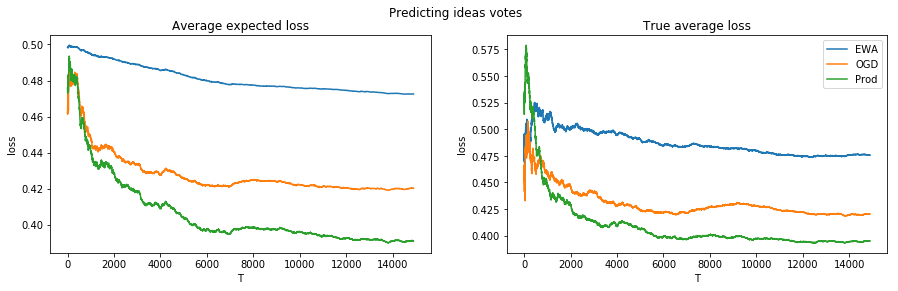

In [5]:
t_0 = 100 # first t_0 losses vary too much and prevent the visualization of results
fig,ax=plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15, 4))
for f, result in res_ideas.items():
    for i, sp in enumerate(ax):
        sp.plot(result[i][t_0:], label=f)
titles=['Average expected loss', 'True average loss']
for i,sp in enumerate(ax):
    sp.set_title(titles[i])
    sp.set_xlabel('T')
    sp.set_ylabel('loss')
fig.suptitle('Predicting ideas votes')
plt.legend()
plt.show()

#### 3.2. Trying multiple values of $\eta$ for prod algorithm:

In [6]:
etas = np.linspace(0.0, 0.5,10)[1:]
Ls =[]
for eta in etas:
    Ls.append(run_forecaster(ideas_votes,N,'Prod',False,(eta,))[0])

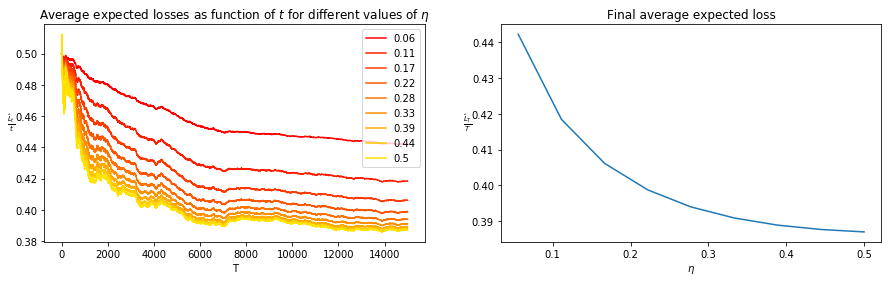

In [7]:
fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
for i,L in enumerate(Ls):
    ax[0].plot(L,label=str(round(etas[i],2)),color=plt.cm.autumn(i/float(len(Ls))))
ax[0].set_xlabel(r'T')
ax[0].set_ylabel(r'$\frac{\hat L_t}{t}$').set_rotation(0)
ax[0].legend(); ax[0].set_title(r'Average expected losses as function of $t$ for different values of $\eta$')
L_T = [L[-1] for L in Ls]
ax[1].plot(etas,L_T)
ax[1].set_xlabel(r'$\eta$')
ax[1].set_ylabel(r'$\frac{\hat L_T}{T}$').set_rotation(0)
ax[1].set_title('Final average expected loss');

### 4. Results for the politicians votes dataset:
#### 4.1 Results for EWA, OGD, and prod algorithm:

In [8]:
N = len(politicians_id)
# dictionary of forecasters:  (forecaster->parameters) (other than T and K)
forecasters= {'EWA':(), 
              'OGD':(np.sqrt(2),np.sqrt(2*N)),
              'Prod':()}
# dictionary of results: (forcaster->(average expected loss, true average loss))
res_politicians = dict()
for f,params in forecasters.items():
     res_politicians[f] = run_forecaster(politicians_votes,N,f,True,*params)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

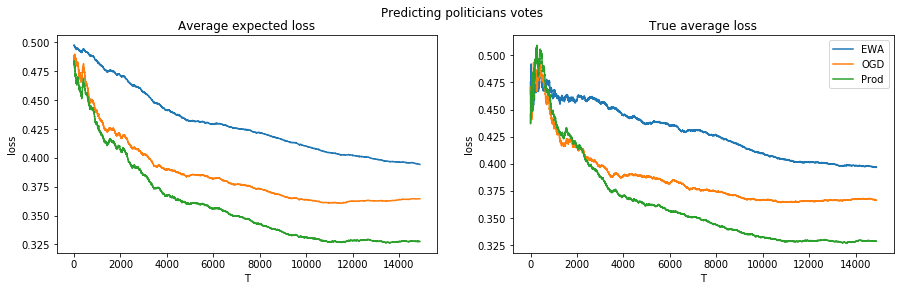

In [9]:
t_0 = 100
fig,ax=plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15, 4))
for f, result in res_politicians.items():
    for i, sp in enumerate(ax):
        sp.plot(result[i][t_0:], label=f)
titles=['Average expected loss', 'True average loss']
for i,sp in enumerate(ax):
    sp.set_title(titles[i])
    sp.set_xlabel('T')
    sp.set_ylabel('loss')
fig.suptitle('Predicting politicians votes')
plt.legend()
plt.show()

#### 4.2. Trying multiple values of $\eta$ for the prod algorithm:

In [10]:
etas = np.linspace(0.0, 0.5,10)[1:]
Ls =[]
for eta in etas:
    Ls.append(run_forecaster(politicians_votes,N,'Prod',False,(eta,))[0])

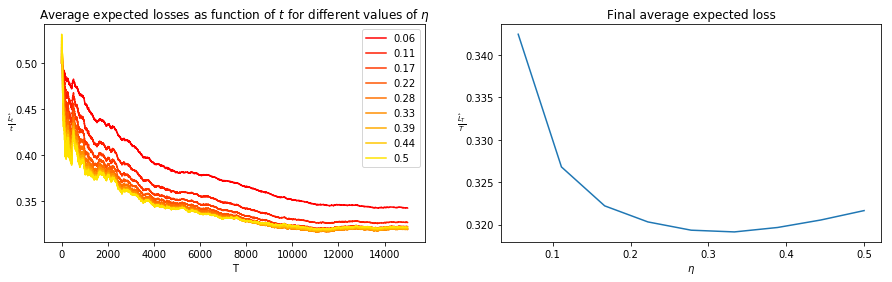

In [11]:
fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
for i,L in enumerate(Ls):
    ax[0].plot(L,label=str(round(etas[i],2)),color=plt.cm.autumn(i/float(len(Ls))))
ax[0].set_xlabel(r'T')
ax[0].set_ylabel(r'$\frac{\hat L_t}{t}$').set_rotation(0)
ax[0].legend(); ax[0].set_title(r'Average expected losses as function of $t$ for different values of $\eta$')
L_T = [L[-1] for L in Ls]
ax[1].plot(etas,L_T)
ax[1].set_xlabel(r'$\eta$')
ax[1].set_ylabel(r'$\frac{\hat L_T}{T}$').set_rotation(0)
ax[1].set_title('Final average expected loss');

### 5. trying other forecasters:

In [12]:
class EG:
    '''The Exponentiated Gradient'''
    def __init__(self, T, K, G, nu = None):
        self.T = T
        self.K = K
        self.p = np.repeat(1/float(K),K)  # p tilde
        self.q = self.p.copy()            # p (p tilde values to 0 for sleeping experts and renormalizing)
        self.prob = list()                # list of probability predictions
        self.pred = list()                # list of predictions
        
        if nu is None :
            # from upper bound optimization if not specified
            self.nu = np.sqrt(np.log(K)/T)/G
        else :
            self.nu = nu
            
    def predict(self, f, y):
        # prediction
        self.q = self.p.copy()
        self.q[np.isnan(f)]=0
        self.q/=self.q.sum()
        
        y_hat = np.nansum(self.q*f)
        self.prob.append(y_hat)
        self.pred.append(np.random.uniform()<y_hat)
        # updating p tilde
        self.p*=np.exp(-self.nu * grad_l(self.q,f,y))
        self.p/=self.p.sum()
        
class BradleyT:
    '''Bradley-Terry model'''
    def __init__(self, T, K):
        self.T = T
        self.K = K
        self.p = np.repeat(1/float(K),K)  # p 
        self.w = np.zeros((K,K))+1e-10    # number of wins of i against j
        self.prob = list()                # list of probability predictions
        self.pred = list()                # list of predictions
            
    def predict(self,indices, y):
        # prediction
        r = self.p[indices]
        y_hat = r[0]/(r[0]+r[1])
        self.prob.append(y_hat)
        self.pred.append(np.random.uniform()<y_hat)
        # updating p tilde
        self.w[indices[0],indices[1]] += y
        self.w[indices[1],indices[0]] += 1-y
        temp = (self.w+self.w.T)/(self.p[None,:]+self.p[:,None])
        self.p = np.sum(self.w,axis=1)/(np.sum(temp,axis=1)-np.diagonal(temp))
        self.p/=self.p.sum()
                   
def run_BT(data, N,verbose):
    T = len(data)
    F=BradleyT(T,N)
    exp_loss = [0]  # average expected loss
    avg_loss = [0]  # true average loss
    if verbose:
        rg = tqdm_notebook(range(T),desc='Running forecaster Bradley-Terry:')
    else:
        rg = range(T)
    for t in rg:
        # reading data
        data_t = data.loc[t+1]
        z1, z2 = data_t[['z1','z2']]-1
        y = data_t['y']
        # getting predictions and updating the forecaster
        F.predict([z1,z2],y)
        # adding new losses
        exp_loss.append(exp_loss[-1]+((1-F.prob[-1])*y+F.prob[-1]*(1-y) - exp_loss[-1])/float(t+1))
        avg_loss.append(avg_loss[-1]+((F.pred[-1]!=y)-avg_loss[-1])/float(t+1))
    exp_loss.pop(0)
    avg_loss.pop(0)    
    return exp_loss, avg_loss

In [13]:
N = len(ideas_id)
bonus_res =dict()
bonus_res['EG ideas'] = run_forecaster(ideas_votes,N,'EG',True,(1.0,))
bonus_res['Bradley-Terry ideas'] = run_BT(ideas_votes,N,True)
N = len(politicians_id)
bonus_res['EG politicians'] = run_forecaster(politicians_votes,N,'EG',True,(1.0,))
bonus_res['Bradley-Terry politicians'] = run_BT(politicians_votes,N,True)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

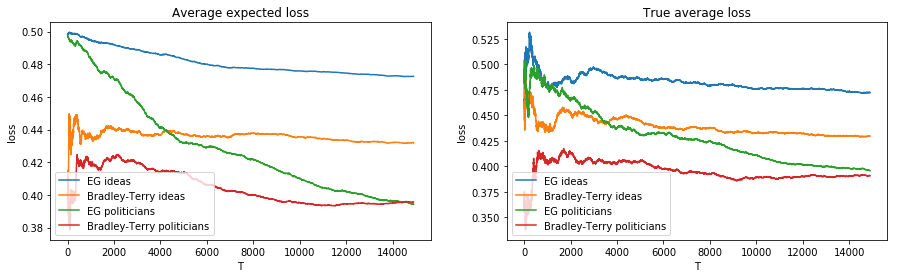

In [14]:
t_0 = 100
fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
titles=['Average expected loss', 'True average loss']
for i in range(len(ax)):
    for f, res in bonus_res.items():
        ax[i].plot(res[i][t_0:],label=f)
    ax[i].set_xlabel(r'T')
    ax[i].set_ylabel('loss')
    ax[i].set_title(titles[i])
    ax[i].legend()